# Predict future sales

This is Run All notebook to generate ~0.88 solution.

Requirements:
- numpy
- scipy
- matplotlib
- sklearn
- xgboost  (I used gpu version; with cpu version will be slightly different)
- pandas

In [ ]:
# Choose your xgboost implementation, CPU or GPU
# If you use GPU, remember that xgboost predictions on test may be incorrect sometimes
# In that case, you should rerun cells with test predictions
GPU = False

In [ ]:
if GPU:
    TREE_METHOD = 'gpu_hist'
else:
    TREE_METHOD = 'auto'

### Libraries and general functions

In [1]:
from scipy.sparse import save_npz, load_npz, hstack, vstack
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import KFold
from functools import partial
import numpy as np
import itertools as it
import pandas as pd
import xgboost as xgb
import warnings
import time
import gc

Filter some annoying pandas warnings.

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
def clip_month_counts(counts):
    """Results should be clipped to [0, 20] range"""
    return np.clip(counts, 0, 20)

In [4]:
def save_submit_results(test_id, test_counts, save_name):
    """Perform output postprocessing and save results to .csv"""
    # Last cliping
    test_counts = clip_month_counts(test_counts)
    
    if not save_name.endswith('.csv'):
        save_name += '.csv'
    
    results = pd.DataFrame(data={'ID': test_id.astype(int),
                                 'item_cnt_month': test_counts.astype(float)})
    results.to_csv(save_name, index=False)

In [5]:
items = pd.read_csv('items.csv', index_col='item_id')
item_categories = pd.read_csv('item_categories.csv', index_col='item_category_id')
shops = pd.read_csv('shops.csv', index_col='shop_id')

sales_train = pd.read_csv('sales_train.csv.gz')
sales_test = pd.read_csv('test.csv.gz', index_col='ID')

## Feature extraction and generation

#### Preprocessing from course notebooks

In [6]:
# Aggregate the data to a monthly level and add rows for missing sales
def preprocess_train():
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales_train['date_block_num'].unique():
        cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
        cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
        grid.append(np.array(list(it.product(*[cur_shops, cur_items, [block_num]])),
                             dtype='int32'))

    # turn the grid into pandas dataframe
    grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

    # get aggregated values for (shop_id, item_id, month)
    gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})

    # fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    # join aggregated data to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
    # sort the data
#     all_data.sort_values(['date_block_num','shop_id','item_id'], inplace=True)  # NO SORTING TO DO MAGIC!
    all_data.reset_index(inplace=True, drop=True)
    all_data.target = all_data.target.astype(np.float32)
    return all_data
train = preprocess_train()

c:\python36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


#### Item category

In [7]:
FEATURE_ITEM_CATEGORY_ID = 'item_category_id'
def create_item_category(tr, test, new_col=FEATURE_ITEM_CATEGORY_ID):
    tr[new_col] = tr['item_id'].map(items[new_col]).astype(np.int32)
    test[new_col] = test['item_id'].map(items[new_col]).astype(np.int32)
create_item_category(train, sales_test)

#### Lagged features

In [8]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
test_index_cols = ['shop_id', 'item_id']
cols_to_rename = ['target']

shift_range = [1, 2, 3, 6, 12]

for month_shift in shift_range:
    train_shift = train[index_cols + cols_to_rename].copy()

    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    train = pd.merge(train, train_shift, on=index_cols, how='left').fillna(0)

    # Test
    test_month_shift = 34 - month_shift
    test_shift = train.loc[train.date_block_num == test_month_shift, test_index_cols + cols_to_rename].copy()
    test_shift = test_shift.rename(columns=foo)
    
    sales_test = pd.merge(sales_test, test_shift, on=test_index_cols, how='left').fillna(0)

lagged_features = [col for col in train.columns if 'lag' in col]
del train_shift, test_shift
gc.collect();

#### Text features

In [9]:
# Sklearn TfidfVectorizer do all necessary preprocessing
# Save mappers to original columns
# I also drop some useless words
train_tf_idf_features = {}
test_tf_idf_features = {}
texts = [item_categories.item_category_name, shops.shop_name, items.item_name]
text_names = ['item_category_id', 'shop_id', 'item_id']

print('Generate text features')
stop_words = {
    'item_category_id': ['для'],
    'shop_id': ['тц', 'тк', 'трк', 'трц', 'ii', 'ул', 'пав'],
    'item_id': ['the', 'для', 'of', 'на']
}
for name, text in zip(text_names, texts):
    print(f'Extract from {name}')
    vectorizer = TfidfVectorizer(max_features=30, stop_words=stop_words[name])
    tf_idf_feats = vectorizer.fit_transform(text)

    means = np.array(tf_idf_feats.mean(axis=0)).squeeze()
    argsort = means.argsort()
    print('Top frequency words:')
    print(np.array(vectorizer.get_feature_names())[argsort[::-1][:30]])
    print()

    # Create and save
    print('Transform data')
    sparse_text_train = vectorizer.transform(train[name].map(text))
    sparse_text_test = vectorizer.transform(sales_test[name].map(text))
    train_tf_idf_features[name] = sparse_text_train
    test_tf_idf_features[name] = sparse_text_test

    print('Save to file')
    save_npz(name + '_tf_idf_train', sparse_text_train)
    save_npz(name + '_tf_idf_test', sparse_text_test)
    print()
print('Success!')

Generate text features
Extract from item_category_id
Top frequency words:
['подарки' 'игры' 'книги' 'цифра' 'музыка' 'аксессуары' 'программы'
 'консоли' 'игровые' 'кино' 'pc' 'xbox' 'литература' 'карты' 'оплаты'
 'издания' 'psp' 'ps2' 'ps3' 'ps4' 'psvita' '1с' 'аудиокниги' 'one' '360'
 'blu' 'ray' 'открытки' 'производства' 'офиса']

Transform data
Save to file

Extract from shop_id
Top frequency words:
['москва' 'мега' 'тюмень' 'воронеж' 'молл' 'якутск' 'красноярск' 'спб'
 'центральный' 'ростовнадону' 'век' 'магазин' 'новосибирск' 'уфа' 'рио'
 'самара' 'казань' 'буденовский' 'чкалова' 'паркхаус' 'жуковский'
 'новгород' 'сити' 'мегацентр' 'горизонт' 'фран' '56' 'орджоникидзе'
 'фантастика' 'парк']

Transform data
Save to file

Extract from item_id
Top frequency words:
['bd' 'регион' 'версия' 'pc' 'цифровая' 'русская' 'jewel' '1с' 'dvd'
 'фирм' 'фигурка' 'cd' 'lp' 'mp3' 'ps3' 'xbox' 'edition' 'коллекция' '3d'
 'арт' 'digipack' '2cd' 'футболка' 'игрушка' 'сб' 'игра' '360' 'русские'
 'субт

#### Reduce train size

In [10]:
start_month = 6
reduce_mask = train.date_block_num > start_month
train = train[reduce_mask]
train.reset_index(inplace=True, drop=True)

for name in train_tf_idf_features:
    train_tf_idf_features[name] = train_tf_idf_features[name][reduce_mask.values]

del reduce_mask
gc.collect();

#### Magic feature

In [11]:
FEATURE_INTERNAL_INDEX = 'internal_index'
def create_first_magic_feature(tr, test, new_col=FEATURE_INTERNAL_INDEX):
    counts_mapping = tr.groupby(['date_block_num', 'shop_id']).shop_id.count()
    counts = pd.Series(list(zip(tr.date_block_num, tr.shop_id))).map(counts_mapping)
    tr[new_col] = (tr.groupby(['date_block_num', 'shop_id']).shop_id.cumcount() / counts).astype(np.float32)

    counts_mapping = test.groupby('shop_id').shop_id.count()
    counts = test.shop_id.map(counts_mapping)
    test[new_col] = (test.groupby('shop_id').shop_id.cumcount() / counts).astype(np.float32)

create_first_magic_feature(train, sales_test)

In [12]:
FEATURE_ITEM_ID_FREQS = 'item_id_freqs'
def create_second_good_feature(tr, test, new_col=FEATURE_ITEM_ID_FREQS):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[1:]:
        prev_mask = (sales_train.date_block_num == month_num-1)
        prev_mapping = sales_train[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = sales_train.date_block_num == tr.date_block_num.max()
    full_mapping = sales_train[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

create_second_good_feature(train, sales_test)

In [13]:
FEATURE_ITEM_ID_FREQS2 = 'item_id_freqs2'
def create_third_good_feature(tr, test, new_col=FEATURE_ITEM_ID_FREQS2):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[2:]:
        prev_mask = (sales_train.date_block_num == month_num-2)
        prev_mapping = sales_train[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = sales_train.date_block_num == tr.date_block_num.max() - 1
    full_mapping = sales_train[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

create_third_good_feature(train, sales_test)

### Mean encoding

In [14]:
cat_columns = ['shop_id', 'item_id', 'item_category_id']
global_mean = train.target.mean()
current_encoder = ''
enc_features = {}

In [15]:
def get_enc_name(col):
    return f'{col}_enc'

def get_enc_features():
    enc_ = [feat for feat in enc_features if 'enc' in feat]
    return enc_

def clear_enc_features():
    for feature in get_enc_features():
        if feature in enc_features:
            del enc_features[feature]

In [16]:
# Using expanding mean
def create_expand_mean_enc(tr, test, col):
    new_col_name = get_enc_name(col)
    tr[new_col_name] = np.nan

    cumsum = tr.groupby(col)['target'].cumsum() - tr['target']
    cumcount = tr.groupby(col)['target'].cumcount()

    expanding_mean = pd.DataFrame({'expand_mean': cumsum / cumcount,
                                   'date_block_num': tr.date_block_num,
                                   col: tr[col]})
    for block_num in np.unique(tr.date_block_num)[1:]:
        cur_mask = tr.date_block_num == block_num
        prev_mask = tr.date_block_num <= block_num - 1
        
        mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
        tr.loc[cur_mask, new_col_name] = tr.loc[cur_mask, col].map(mapping)
        
    
    # Fill train with last seen values from train
    prev_mask = tr.date_block_num <= tr.date_block_num.max()
    mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
    test[new_col_name] = test[col].map(mapping)
    
    # Downcast
    tr[new_col_name] = tr[new_col_name].astype(np.float32)
    test[new_col_name] = test[new_col_name].astype(np.float32)
    
    # Fill NaNs
    tr[new_col_name].fillna(global_mean, inplace=True) 
    tr[new_col_name].replace(np.inf, global_mean, inplace=True)

    test[new_col_name].fillna(global_mean, inplace=True) 
    test[new_col_name].replace(np.inf, global_mean, inplace=True)

clear_enc_features()
for col in cat_columns:
    enc_features[get_enc_name(col)] = partial(create_expand_mean_enc, col=col)
current_encoder = 'expand_mean_enc'

In [17]:
# Global train encoding
print(f'Using {current_encoder}')
for feat in get_enc_features():
    enc_func = enc_features[feat]
    enc_func(train, sales_test)

Using expand_mean_enc


## Validation

In [18]:
def make_folds(data, last_k_month=3, except_month=(), ret_month=False):
    n_month = data.date_block_num.max()
    
    for k in range(0, n_month):
        # Stop iter
        if last_k_month == 0:
            return
        
        test_month = n_month - k
        
        if test_month in except_month:
            continue
        
        train_mask = data.date_block_num < test_month
        test_mask = data.date_block_num == test_month
        print(f'pick month {test_month} as test; '
              f'train size {train_mask.sum()}, test size {test_mask.sum()}')
        if ret_month:
            yield train_mask, test_mask, test_month
        else:
            yield train_mask, test_mask
        last_k_month -= 1

## Models

### XGBoost

In [19]:
def gbdt_val_score(model_cls, train_columns, n_folds=5, except_month=(26, 30, 31, 33),
                   verbose_=True, **model_params):
    if verbose_:
        print(f'Use columns: {train_columns}')
        print(f'Feature mean encoder: {current_encoder}')
    
    train_rmse = None
    rmse_train_list = []
    rmse_val_list = []
    feature_importances = []
    predictions = []
    preds_months = []
    for i, (train_mask, test_mask, month) in enumerate(make_folds(train, n_folds, ret_month=True,
                                                                  except_month=except_month)):
        if verbose_:
            print(f'Fold {i+1}/{n_folds}')
        train_fold = train.loc[train_mask].copy()
        test_fold = train.loc[test_mask].copy()
        
        train_target = train_fold['target']
        test_target = test_fold['target']
        
        plt.plot(test_fold.shop_id.values[:50000])
        
        cols_to_drop = list(set(train_fold.columns) - set(train_columns))
        train_fold.drop(cols_to_drop, axis=1, inplace=True)
        test_fold.drop(cols_to_drop, axis=1, inplace=True)
        
        assert set(train_fold.columns) == set(train_columns)
        
        if verbose_:
            print(' start training')
        model = model_cls(**model_params)
        model.fit(train_fold.values, train_target.values)
        
        feature_importances.append(model.feature_importances_)
        
        #train_fold_prediction = model.predict(train_fold.values)
        time.sleep(2)  # some gpu issues
        gc.collect()
        test_fold_prediction = model.predict(test_fold.values)
        predictions.append(test_fold_prediction)
        preds_months.append(np.full(test_fold_prediction.size, month))
        #train_rmse = mean_squared_error(clip_month_counts(train_target.values),
        #                                clip_month_counts(train_fold_prediction)) ** 0.5
        test_rmse = mean_squared_error(clip_month_counts(test_target.values),
                                       clip_month_counts(test_fold_prediction)) ** 0.5
        if verbose_:
            print(f' train fold rmse: {train_rmse}')
            print(f' test fold rmse: {test_rmse}')
        
        #rmse_train_list.append(train_rmse)
        rmse_val_list.append(test_rmse)
        
        if model_cls == xgb.XGBRegressor:
            model.get_booster().__del__()
            
        
        plt.twinx()
        plt.plot(test_fold_prediction[:50000], color='red')
        plt.ylim(0, None)
        plt.show()
    
    #train_rmse = np.mean(rmse_train_list)
    #print('\nTrain mean RMSE: {} (std = {})'.format(train_rmse, np.std(rmse_train_list)))
    val_rmse = np.mean(rmse_val_list)
    print('Validation mean RMSE: {} (std = {})'.format(val_rmse, np.std(rmse_val_list)))
    
    if verbose_:
        print('Feature importances:')
        for col, imp in zip(train_columns, np.mean(feature_importances, axis=0)):
            print(f'{col}: {imp:.4f}')
    
    oof_predictions = pd.DataFrame({'target': np.concatenate(predictions[::-1]),
                                    'date_block_num': np.concatenate(preds_months[::-1])})
    
    return oof_predictions, train_rmse, val_rmse

In [20]:
best_lb_params = {
    'max_depth': 6,
    'tree_method': TREE_METHOD
}

#### Generate meta-predictions
OOF predictions.

Use columns: ['internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12', 'shop_id_enc', 'item_id_enc', 'item_category_id_enc']
Feature mean encoder: expand_mean_enc
pick month 33 as test; train size 8026340, test size 238172
Fold 1/12
 start training
 train fold rmse: None
 test fold rmse: 0.9348904849495379


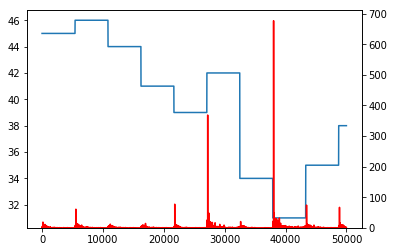

pick month 32 as test; train size 7807685, test size 218655
Fold 2/12
 start training
 train fold rmse: None
 test fold rmse: 0.919481143542338


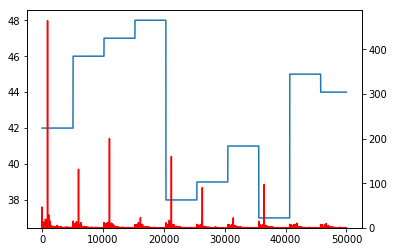

pick month 31 as test; train size 7593149, test size 214536
Fold 3/12
 start training
 train fold rmse: None
 test fold rmse: 0.8040932989170736


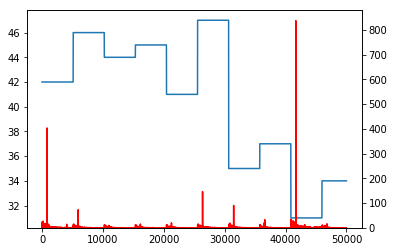

pick month 30 as test; train size 7364260, test size 228889
Fold 4/12
 start training
 train fold rmse: None
 test fold rmse: 0.7201564959150918


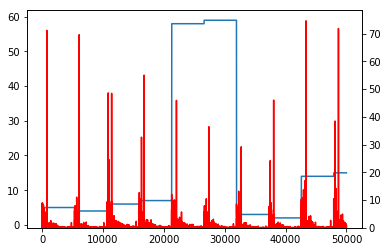

pick month 29 as test; train size 7139972, test size 224288
Fold 5/12
 start training
 train fold rmse: None
 test fold rmse: 0.847825556428503


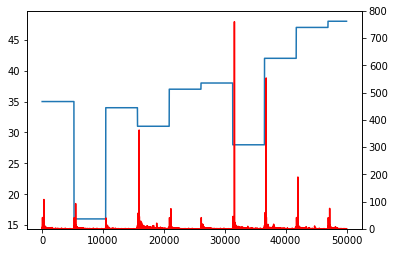

pick month 28 as test; train size 6907520, test size 232452
Fold 6/12
 start training
 train fold rmse: None
 test fold rmse: 0.8239344969981703


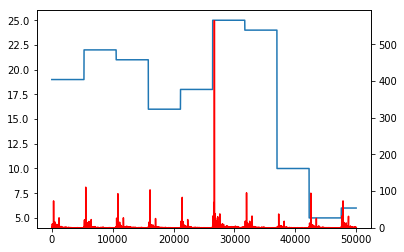

pick month 27 as test; train size 6650148, test size 257372
Fold 7/12
 start training
 train fold rmse: None
 test fold rmse: 0.9134599052445487


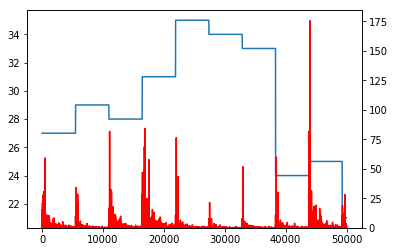

pick month 26 as test; train size 6370376, test size 279772
Fold 8/12
 start training
 train fold rmse: None
 test fold rmse: 0.8174723549931083


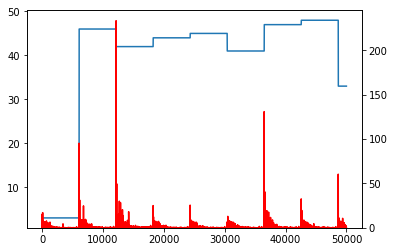

pick month 25 as test; train size 6085885, test size 284491
Fold 9/12
 start training
 train fold rmse: None
 test fold rmse: 0.8191053318320988


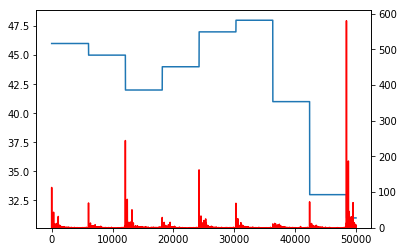

pick month 24 as test; train size 5778935, test size 306950
Fold 10/12
 start training
 train fold rmse: None
 test fold rmse: 0.8703252370234479


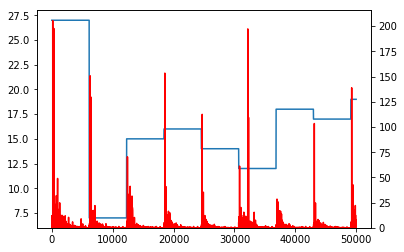

pick month 23 as test; train size 5448685, test size 330250
Fold 11/12
 start training
 train fold rmse: None
 test fold rmse: 1.1869936917755208


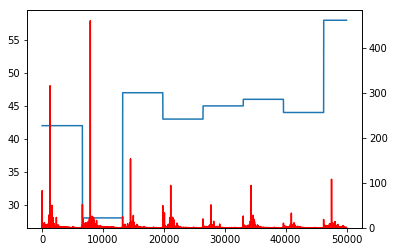

pick month 22 as test; train size 5132585, test size 316100
Fold 12/12
 start training
 train fold rmse: None
 test fold rmse: 0.9979912430698222


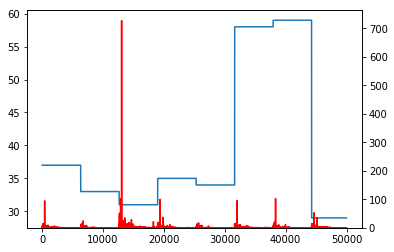

Validation mean RMSE: 0.8879774367241052 (std = 0.11412582753139844)
Feature importances:
internal_index: 0.1559
item_id_freqs: 0.0847
item_id_freqs2: 0.0738
target_lag_1: 0.0546
target_lag_2: 0.0415
target_lag_3: 0.1854
target_lag_6: 0.0727
target_lag_12: 0.0478
shop_id_enc: 0.1508
item_id_enc: 0.0419
item_category_id_enc: 0.0909


In [21]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
train_columns += get_enc_features()


oof_preds, _, _ = gbdt_val_score(xgb.XGBRegressor, n_folds=12, 
                                 train_columns=train_columns,
                                 except_month=(),
                                 **best_lb_params)

In [22]:
oof_preds.to_csv('OOF_xgb_basic.csv', index=False)

#### Final predictions

In [35]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2'
]
train_columns += lagged_features
train_columns += get_enc_features()

train_columns

['internal_index',
 'item_id_freqs',
 'item_id_freqs2',
 'target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_6',
 'target_lag_12',
 'shop_id_enc',
 'item_id_enc',
 'item_category_id_enc']

In [24]:
model = xgb.XGBRegressor(**best_lb_params)
model.fit(train[train_columns].values, train['target'].values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [25]:
train_prediction = model.predict(train[train_columns].values)
# train_prediction = rounding(train_prediction)
train_rmse = mean_squared_error(clip_month_counts(train['target']),
                                clip_month_counts(train_prediction)) ** 0.5
print('Train rmse:', train_rmse)

Train rmse: 0.8892706561988588


In [39]:
predictions = model.predict(sales_test[train_columns].values)

In [ ]:
plt.plot(sales_test.shop_id.values[5000:20000])
plt.twinx()
plt.plot(predictions[5000:20000], color='red')
plt.ylim(0, None)
plt.twinx()
plt.plot(sales_test.item_id_freqs.values[5000:20000], color='green', alpha=0.5)
plt.ylim(0, None);

In [41]:
save_submit_results(sales_test.index, predictions, 'xgb_final')

### Linear regression

In [28]:
# Get text features
cols_to_one_hot = ['shop_id', 'item_category_id']
train_text_features = [train_tf_idf_features[name] for name in sorted(train_tf_idf_features)]
test_text_features = [test_tf_idf_features[name] for name in sorted(test_tf_idf_features)]

In [29]:
# One hot encoding
encoders = []
train_one_hot_features = []
test_one_hot_features = []

max_vals = {'shop_id': shops.index.max(),
            'item_category_id': item_categories.index.max(),
            'item_id': items.index.max()}

one_hot = OneHotEncoder(n_values=[max_vals[col]+1 for col in cols_to_one_hot])

train_one_hot = one_hot.fit_transform(train[cols_to_one_hot].values)
train_one_hot_features.append(train_one_hot)

test_one_hot = one_hot.transform(sales_test[cols_to_one_hot].values)
test_one_hot_features.append(test_one_hot)

In [30]:
# Stack everything to sparse format
train_all_sparse_features = train_text_features + [train_one_hot]
test_all_sparse_features = test_text_features + [test_one_hot]
sparse_train = hstack(train_all_sparse_features, format='csr').astype(np.float32)
sparse_test = hstack(test_all_sparse_features, format='csr').astype(np.float32)
gc.collect();

In [31]:
# Reduce dimensions
svd = TruncatedSVD(30)
svd = svd.fit_transform(vstack([sparse_train, sparse_test]))
svd_train = svd[:sparse_train.shape[0]]
svd_test = svd[sparse_train.shape[0]:]
del svd

In [32]:
# This one with scaling
def sparse_data_val_score(model_cls, non_sparse_columns, use_svd=True, n_folds=5, verbose_=True,
                          except_month=(26, 30, 31), scale=True, **model_params):
    
    if verbose_:
        print(f'Use columns: {non_sparse_columns}')    
    
    rmse_train_list = []
    rmse_val_list = []
    predictions = []
    preds_months = []
    for i, (train_mask, test_mask, month) in enumerate(make_folds(train, n_folds,
                                                                  except_month=except_month,
                                                                  ret_month=True)):
        if verbose_:
            print(f'Fold {i+1}/{n_folds}')
        train_fold = train.loc[train_mask].copy()
        test_fold = train.loc[test_mask].copy()
        
        train_target = train_fold['target']
        test_target = test_fold['target']
        
        cols_to_drop = list(set(train_fold.columns) - set(non_sparse_columns))
        train_fold.drop(cols_to_drop, axis=1, inplace=True)
        test_fold.drop(cols_to_drop, axis=1, inplace=True)
        
        assert set(train_fold.columns) == set(non_sparse_columns)
        
        train_fold = train_fold.values
        train_mask = train_mask.values
        train_target = train_target.values
        test_fold = test_fold.values
        test_mask = test_mask.values
        test_target = test_target.values
        
        # Scale
        if scale:
            scaler = MaxAbsScaler()
            train_fold = scaler.fit_transform(train_fold)
            test_fold = scaler.transform(test_fold)
        
        # Concatenate with sparse train
        if use_svd:
            train_fold = np.hstack([train_fold, svd_train[train_mask]])
            test_fold = np.hstack([test_fold, svd_train[test_mask]])
        else:
            train_fold = hstack([train_fold] + [sparse_train[train_mask]])
            test_fold = hstack([test_fold] + [sparse_train[test_mask]])
        
        if verbose_:
            print(' start training')
        model = model_cls(**model_params)
        model.fit(train_fold, train_target)
        
        train_fold_prediction = model.predict(train_fold)
        test_fold_prediction = model.predict(test_fold)
        
        predictions.append(test_fold_prediction)
        preds_months.append(np.full(test_fold_prediction.size, month))
        
        train_rmse = mean_squared_error(clip_month_counts(train_target),
                                        clip_month_counts(train_fold_prediction)) ** 0.5
        test_rmse = mean_squared_error(clip_month_counts(test_target),
                                       clip_month_counts(test_fold_prediction)) ** 0.5
        if verbose_:
            print(f' train fold rmse: {train_rmse}')
            print(f' test fold rmse: {test_rmse}')
        
        rmse_train_list.append(train_rmse)
        rmse_val_list.append(test_rmse)
            
    train_rmse = np.mean(rmse_train_list)
    val_rmse = np.mean(rmse_val_list)
    
    print('\nTrain mean RMSE: {} (std = {})'.format(train_rmse, np.std(rmse_train_list)))
    print('Validation mean RMSE: {} (std = {})'.format(val_rmse, np.std(rmse_val_list)))
    
    oof_predictions = pd.DataFrame({'target': np.concatenate(predictions[::-1]),
                                    'date_block_num': np.concatenate(preds_months[::-1])})
    return oof_predictions, train_rmse, val_rmse

#### Meta-predictions

In [42]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features

params = {'alpha': 4.11}  # Tuned value

oof_preds, _, _ = sparse_data_val_score(Ridge, n_folds=12, non_sparse_columns=train_columns,
                                        use_svd=True, verbose_=False, except_month=(),
                                        **params)

pick month 33 as test; train size 8026340, test size 238172
pick month 32 as test; train size 7807685, test size 218655
pick month 31 as test; train size 7593149, test size 214536
pick month 30 as test; train size 7364260, test size 228889
pick month 29 as test; train size 7139972, test size 224288
pick month 28 as test; train size 6907520, test size 232452
pick month 27 as test; train size 6650148, test size 257372
pick month 26 as test; train size 6370376, test size 279772
pick month 25 as test; train size 6085885, test size 284491
pick month 24 as test; train size 5778935, test size 306950
pick month 23 as test; train size 5448685, test size 330250
pick month 22 as test; train size 5132585, test size 316100

Train mean RMSE: 1.0248539653861684 (std = 0.016413248367339317)
Validation mean RMSE: 0.9666151033965539 (std = 0.12281412173264103)


In [43]:
oof_preds.to_csv('OOF_ridge_tuned.csv', index=False)

#### Test predictions

In [44]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
params = {'alpha': 4.11}  # Tuned value
model = Ridge(**params)

In [45]:
def predict_test(model_cls, model_params, train_columns=train_columns,
                 use_svd=True, scale=True):
    target = train.target.values

    # Scale
    if scale:
        scaler = MaxAbsScaler()
        train_fold = scaler.fit_transform(train[train_columns].values)
        test_fold = scaler.transform(sales_test[train_columns].values)

    # Concatenate with sparse train
    if use_svd:
        train_fold = np.hstack([train_fold, svd_train])
        test_fold = np.hstack([test_fold, svd_test])
    else:
        train_fold = hstack([train_fold] + [sparse_train])
        test_fold = hstack([test_fold] + [sparse_test])
    
    model.fit(train_fold, target)
    train_preds = model.predict(train_fold)
    test_preds = model.predict(test_fold)
    return train_preds, test_preds
ridge_train_preds, ridge_test_preds = predict_test(model, params)

In [46]:
save_submit_results(sales_test.index, ridge_test_preds, 'ridge_final')

### Stacking
Via linear combination. Search coefficient for both predictions separately.

In [47]:
n_oof_month = 12
oof_predictions_files = [
    'OOF_xgb_basic.csv',
    'OOF_ridge_tuned.csv',
]
test_predictions_files = [
    'xgb_final.csv',
    'ridge_final.csv'
]

In [48]:
meta_predictions = [pd.read_csv(filename) for filename in oof_predictions_files]
test_predictions = [pd.read_csv(filename) for filename in test_predictions_files]
meta_target = train.target[train.date_block_num > 33 - n_oof_month]
meta_target.reset_index(inplace=True, drop=True)

In [49]:
meta_predictions = pd.DataFrame({'date_block_num': meta_predictions[0]['date_block_num'],
                                 'target_xgb': meta_predictions[0]['target'],
                                 'target_ridge': meta_predictions[1]['target']})

test_predictions = pd.DataFrame({'target_xgb': test_predictions[0]['item_cnt_month'],
                                 'target_ridge': test_predictions[1]['item_cnt_month']})

In [50]:
best_alpha = 1.
best_beta = 1.
best_rmse = 99999
for alpha in np.linspace(0.5, 1, 50):
    print(alpha)
    for beta in np.linspace(-1, 1, 50):
        preds = meta_predictions['target_xgb'].values * alpha + meta_predictions['target_ridge'] * beta
        rmse = mean_squared_error(clip_month_counts(meta_target.values),
                                  clip_month_counts(preds)) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_beta = beta
print(f'Best alpha: {best_alpha}, best beta: {best_beta} with rmse {best_rmse}')

0.5
0.5102040816326531
0.5204081632653061
0.5306122448979592
0.5408163265306123
0.5510204081632653
0.5612244897959183
0.5714285714285714
0.5816326530612245
0.5918367346938775
0.6020408163265306
0.6122448979591837
0.6224489795918368
0.6326530612244898
0.6428571428571428
0.6530612244897959
0.6632653061224489
0.673469387755102
0.6836734693877551
0.6938775510204082
0.7040816326530612
0.7142857142857143
0.7244897959183674
0.7346938775510203
0.7448979591836735
0.7551020408163265
0.7653061224489796
0.7755102040816326
0.7857142857142857
0.7959183673469388
0.8061224489795917
0.8163265306122449
0.8265306122448979
0.8367346938775511
0.846938775510204
0.8571428571428571
0.8673469387755102
0.8775510204081632
0.8877551020408163
0.8979591836734693
0.9081632653061225
0.9183673469387754
0.9285714285714286
0.9387755102040816
0.9489795918367346
0.9591836734693877
0.9693877551020408
0.9795918367346939
0.9897959183673469
1.0
Best alpha: 0.6632653061224489, best beta: 0.18367346938775508 with rmse 0.8888981

In [51]:
stacked_predictions = (test_predictions['target_xgb'].values * best_alpha
                       + test_predictions['target_ridge'] * best_beta)

In [52]:
# Here we are
save_submit_results(sales_test.index, stacked_predictions, 'stacked_final')

Thanks for reading!